In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import SimpleITK as sitk
from ipywidgets import interact, fixed
from tqdm.notebook import tqdm 
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from torch.autograd import Variable

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from transformers import get_linear_schedule_with_warmup
import albumentations as A 
from collections import OrderedDict
import random
import gc
import itertools

from loss.ssim import * 
from models.UNet import *
from datasets.merging_dataset import * 

In [3]:
# SEED Everything 

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Adversarial 

In [8]:
class Adeversarial(nn.Module) : 
    def __init__(self) : 
        super(Adeversarial, self).__init__()
        
        self.image_encoder = nn.Sequential(
            nn.Conv2d(1, 128, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 128 , kernel_size = 5), 
            nn.ReLU(inplace=True), 
            nn.MaxPool2d(kernel_size = 2 , stride=2),
        
            nn.Conv2d(128, 128, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(256, 512, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 2, kernel_size=3),
            nn.MaxPool2d(kernel_size=3, stride=3),
            nn.Sigmoid()
        
        )
        
    def forward(self, image):
        y = self.image_encoder(image)
        return(y[:,:,0,0])
            

# Loss function

In [9]:
#ssim

In [12]:
def cross_entropy_loss(y_hat, y) : 
    return nn.CrossEntropyLoss()(y_hat,y)

In [13]:
def loss_fn (img1, img2):
    return 1-SSIM()(img1, img2)

In [14]:
class LambdaLR():
    def __init__(self, n_epochs, offset, decay_start_epoch):
        assert ((n_epochs - decay_start_epoch) > 0), "Decay must start before the training session ends!"
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch

    def step(self, epoch):
        return 1.0 - max(0, epoch + self.offset - self.decay_start_epoch)/(self.n_epochs - self.decay_start_epoch)

# Train function

In [15]:
def train_fn( data_loader, netG_L2H, netG_H2L, netD_L , netD_H, optimizerG , optimizerD ):
    
    netG_L2H.train()
    netG_H2L.train()
    netD_L.train()
    netD_H.train()
   
    malek = 0
    naim = 0
    
    GL2H_loss = 0 
    GH2L_loss = 0
    D_L_loss = 0 
    D_H_loss = 0
    counter = 0 
    train_ssim = 0 
    
    if verbose : 
        tk0 = tqdm(enumerate(data_loader), total=len(data_loader))
    else : 
        tk0 = enumerate(data_loader)
    for bi, d in tk0 : # LOOP : batch number i    
        
        y = d["HR"].to(device, dtype=torch.float)
        x = d["LR"].to(device, dtype=torch.float) 
        BATCH_SIZE = x.shape[0]
        
        ### Train The Genrative models L2H and H2L ### 
        
        # Generator L2H 
        optimizerG.zero_grad()   
        
        img_lr = Variable((torch.ones(BATCH_SIZE)).to(device , dtype = torch.long)) 
        gener_hr = netG_L2H(x.unsqueeze(1)) #generate HR img from LR img
        
        pred_fake1 = netD_L(gener_hr.detach()) #predict 1 (discriminator)
        
        
        ##loss function
        loss_GL2H = loss_fn(gener_hr, y.unsqueeze(1)) #loss fn (ssim) y_hat and y 
        train_ssim += loss_GL2H.item()
        loss_class1 = cross_entropy_loss(pred_fake1, img_lr) #loss fn(cross entropy) fake and real
        
        
        loss_L2H = loss_GL2H*0.6 + loss_class1*0.4
        
        
        # Generator H2L
        img_hr = Variable((torch.ones(BATCH_SIZE)).to(device , dtype = torch.long) ) 
        gener_lr = netG_H2L(y.unsqueeze(1))
    
        pred_fake2 = netD_H(gener_lr.detach()) #predict 1 (discriminator)
        
        
        #loss function
        loss_GH2L = loss_fn(gener_lr, x.unsqueeze(1))
        loss_class2 = cross_entropy_loss(pred_fake2, img_hr) #loss fn(cross entropy) fake and real
        
        loss_H2L = loss_GH2L*0.6 + loss_class2*0.4
        

        # Cycle loss
        reconstruct_lr_img = netG_H2L(gener_hr)
        loss_cycle_LHL = loss_fn(reconstruct_lr_img, x.unsqueeze(1)) #loss fn cycle L2H then H2L
        
        reconstruct_hr_img = netG_L2H(gener_lr)
        loss_cycle_HLH = loss_fn(reconstruct_hr_img, y.unsqueeze(1)) #loss fn cycle H2L then L2H

        
        loss_G = loss_L2H + alpha*loss_H2L + lambda_* ( loss_cycle_LHL + loss_cycle_HLH ) 
        
        malek+= (loss_L2H + loss_H2L).item()
        naim+= ( lambda_* ( loss_cycle_LHL + loss_cycle_HLH ) ).item()
        
        GL2H_loss += loss_G.item() 
        loss_G.backward(retain_graph=True)
        
        optimizerG.step()
        
        ### Train the Adversial model 
        
        optimizerD.zero_grad()    
      
        img  = Variable((torch.ones(BATCH_SIZE)).to(device , dtype = torch.long), requires_grad=False)
        output = netD_L(x.unsqueeze(1))
        lossDL_real  = cross_entropy_loss(output, img)
        
        img = Variable((torch.zeros(BATCH_SIZE)).to(device, dtype = torch.long), requires_grad=False)
        lossDL_fake  = cross_entropy_loss(pred_fake1, img)
        
        #loss D lr
        lossDL = (lossDL_real + lossDL_fake)/2
        
        img  = Variable((torch.ones(BATCH_SIZE)).to(device , dtype = torch.long), requires_grad=False)
        output = netD_H(y.unsqueeze(1))
        lossDH_real  = cross_entropy_loss(output, img)
        
        img = Variable((torch.zeros(BATCH_SIZE)).to(device, dtype = torch.long), requires_grad=False)
        lossDH_fake  = cross_entropy_loss(pred_fake2, img)
        
        #loss D hr
        lossDH = (lossDH_real + lossDH_fake)/2
        
        D_L_loss += lossDL.item()
        D_H_loss += lossDH.item()
        lossDL.backward(retain_graph=True)
        lossDH.backward(retain_graph=True)
        optimizerD.step()

      
        counter += 1 
        
    return GL2H_loss/counter , D_L_loss/counter  , train_ssim/counter, malek/counter, naim/counter

# Evaluation function

In [16]:
def eval_fn(data_loader, model):
    model.eval()
    tr_loss = 0
    counter = 0

    if verbose : 
        tk0 = tqdm(enumerate(data_loader), total=len(data_loader))
    else : 
        tk0 = enumerate(data_loader)
    with torch.no_grad():
        
        for bi, d in tk0 :
       
            y = d["HR"].to(device, dtype=torch.float)
            x = d["LR"].to(device, dtype=torch.float) 
            x = x.unsqueeze(1)
            
            y_hat = model(x) #forward prop
            y = y.unsqueeze(1)
            
            loss = loss_fn(y_hat, y) # Loss calaculation of batch i 
            
            
            tr_loss += loss.item()
            counter +=1 

        
            
        return tr_loss/counter 

In [17]:
gc.collect()

46

# Run function

In [18]:
def run (netG_L2H, netG_H2L, netD_L, netD_H, TRAIN_BATCH_SIZE, VALID_BATCH_SIZE,EPOCHS):
    
    train_data_loader = torch.utils.data.DataLoader(
        train_dataset,
        shuffle = True , 
        batch_size=TRAIN_BATCH_SIZE,
        num_workers=8
    )
    
    
    valid_data_loader = torch.utils.data.DataLoader(
        valid_dataset,
        batch_size=VALID_BATCH_SIZE,
        num_workers=4
    )

    

    # Setup Optimizer for G and D
    optimizer_G = torch.optim.Adam(itertools.chain(netG_L2H.parameters(), 
                                                   netG_H2L.parameters()),
                                                   lr=lr)
    optimizer_D_L = torch.optim.Adam(netD_L.parameters(), lr=lr)
    optimizer_D_H = torch.optim.Adam(netD_H.parameters(), lr=lr)

    Dloss = []
    Gloss = []
    trainloss = []
    valoss = []
    cycle_loss = []
    moch_cycle = []
    
    best_validation_dsc = 1.0
    patience = 0 
    
    for epoch in range(EPOCHS):
        
        if verbose : 
            print(f'--------- Epoch {epoch} ---------')
        elif epoch % 10 == 0 : 
            print(f'--------- Epoch {epoch} ---------')
       
        G_loss ,D_L_loss ,train_ssim, malek, naim  = train_fn(train_data_loader, netG_L2H, netG_H2L, netD_L, netD_H, optimizer_G , optimizer_D_L)
       
        if verbose : 
            print(f"D_loss  = {D_L_loss}       ,     G_loss  = {G_loss}   ,        train_ssim = {train_ssim}")
        elif epoch % 10 == 0 : 
            print(f"D_loss  = {D_L_loss}       ,     G_loss  = {G_loss}   ,        train_ssim = {train_ssim}")

        val  = eval_fn(valid_data_loader, netG_L2H)
        
        if verbose : 
            print(f" val_loss  = {val}")
        elif epoch % 10 == 0 :
            print(f" val_loss  = {val}")
        
        if val < best_validation_dsc : 
            best_validation_dsc =val 
            patience = 0 
            torch.save(netG_L2H.state_dict(), 'netG_L2H.pt')
            torch.save(netG_H2L.state_dict(), 'netG_H2L.pt')
            torch.save(netD_L.state_dict(), 'netD_L.pt')

        else : 
            patience +=1
        
        if patience>10 : 
            print(f'Eraly Stopping on Epoch {epoch}')
            print(f'Best Loss =  {best_validation_dsc}')
            break
        
        Dloss.append(D_L_loss)
        Gloss.append(G_loss)
        trainloss.append(train_ssim)
        valoss.append(val)
        cycle_loss.append(naim)
        moch_cycle.append(malek)
        
    netG_L2H.load_state_dict(torch.load('netG_L2H.pt'), strict=False)
    
    return Dloss, Gloss, trainloss, valoss, cycle_loss, moch_cycle


In [19]:
gc.collect()

23

# Train on Left Hippocampus

In [20]:
data = pd.read_csv('data_5fold.csv')
subjects = data[data['slice']==0]

In [21]:
# hyp par 
lr = 9e-5
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 16
EPOCHS = 100
device = torch.device('cuda')
decay_epoch = 10 
lambda_ = 0.2  
alpha = 0.5

verbose = False

In [ ]:
# 5 folds cross validation
for f in range(1) : 
    
    df_train = data[data['kfold'] !=f]
    df_valid = data[data['kfold'] ==f]
    train_dataset = Merging_data_set(df_train, subjects, Left = True , is_train = True)
    valid_dataset = Merging_data_set(df_valid, subjects, Left = True , is_train  = False)
    
    netG_L2L = UNet(1,1)
    netG_H2L = UNet(1,1)
    netD_L = Adeversarial()
    netD_H = Adeversarial()
    
    netG_L2H = netG_L2L.to(device)
    netG_H2L = netG_H2L.to(device)
    netD_L = netD_L.to(device)
    netD_H = netD_H.to(device)
    
    Dloss, Gloss, trainloss, valoss, naim, malek = run(netG_L2H, netG_H2L, netD_L, netD_H, TRAIN_BATCH_SIZE, VALID_BATCH_SIZE,EPOCHS)
    torch.save(netG_L2H.state_dict(), f'Cycle GAN Left fold {f}.pt')

[get_training_augmentation]  resize_to: (160, 160)
--------- Epoch 0 ---------
D_loss  = 0.6330202394723892       ,     G_loss  = 1.0371032148599624   ,        train_ssim = 0.457894304394722
 val_loss  = 0.3000496566295624
--------- Epoch 10 ---------
D_loss  = 0.4578775218129158       ,     G_loss  = 0.8236399149894714   ,        train_ssim = 0.2800354927778244
 val_loss  = 0.28859442472457886
--------- Epoch 20 ---------
D_loss  = 0.322398773431778       ,     G_loss  = 0.8863660919666291   ,        train_ssim = 0.27097114741802214
 val_loss  = 0.28947952032089236
--------- Epoch 30 ---------
D_loss  = 0.3174650326371193       ,     G_loss  = 0.8787472212314605   ,        train_ssim = 0.2633221143484116
 val_loss  = 0.28372984766960146


In [19]:
gc.collect()

1280

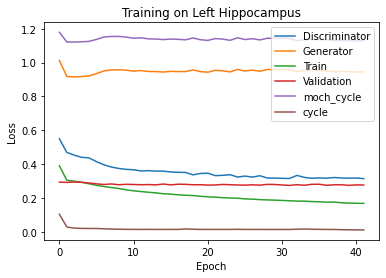

In [20]:
plt.plot(Dloss)
plt.plot(Gloss)
plt.plot(trainloss)
plt.plot(valoss)
plt.plot(malek)
plt.plot(naim)
plt.title('Training on Left Hippocampus')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Generator', 'Train' , 'Validation','moch_cycle', 'cycle'], loc='upper right')
plt.show()